<a href="https://colab.research.google.com/github/vvmnnnkv/private-ai/blob/master/Section_1_Differential_Privacy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: Generate Parallel Databases


In [0]:
import Foundation
import TensorFlow

In [0]:
typealias Database = Tensor<Float>
typealias Query = (_ db: Database) -> Float

/// Return vector of 0 and 1 from uniform distibution
func createRandomBinaryVector(of shape: TensorShape, balance: Float? = 0.5) -> Database {
  return Tensor<Float>(Tensor(randomUniform: shape) .> (balance ?? 0.5))
}


In [0]:
/// Create parallel DB from original DB
func createParallelDb<T>(from tensor: Tensor<T>, dropping index: Int) -> Tensor<T> {
  var top = tensor.slice(lowerBounds: [0], upperBounds: [index])
  var bottom = tensor.slice(lowerBounds: [index + 1], upperBounds: [tensor.shape[0]])
  return top.concatenated(with: bottom)
}

In [0]:
/// Create all possible parallel DBs
func createParallelDbs<T>(from tensor: Tensor<T>) -> Array<Tensor<T>> {
  var result = Array<Tensor<T>>()
  for i in 0 ..< tensor.shape[0] {
    let pdb = createParallelDb(from: tensor, dropping: i)
    result.append(pdb)
  }
  return result
}

In [0]:
/// Create DB and parallal DBs for given number of entries
func createDbAndParallels(entries: Int, balance: Float? = 0.5) -> (db: Database, pdbs: Array<Database>) {
  let db = createRandomBinaryVector(of: [entries], balance: balance)
  let pdbs = createParallelDbs(from: db)
  return (db: db, pdbs: pdbs)
}

In [0]:
var (db, dbs) = createDbAndParallels(entries: 1000)

In [7]:
print(db.shape)
print(dbs.count)
print(dbs[0].shape)

[1000]
1000
[999]


# Project: Evaluating the Privacy of a Function

In [0]:
/// Calculate empirical sensitivity of a query
func sensitivity(of query: Query, with entries: Int, balance: Float? = 0.5) -> Float {
  var (db, pdbs) = createDbAndParallels(entries: entries, balance: balance)
  let dbQuery = query(db)
  var maxDifference:Float = 0
  for pdb in pdbs {
    let pdbQuery = query(pdb)
    let difference = abs(dbQuery - pdbQuery)
    if (maxDifference < difference) {
      maxDifference = difference
    }
  }
  return maxDifference
}

In [0]:
/// Sum query
let sumQuery:Query = { db in db.sum().scalar! }

In [10]:
sensitivity(of: sumQuery, with: 5000)

1.0


In [0]:
/// Mean query
let meanQuery:Query = { db in db.mean().scalar! }

In [12]:
sensitivity(of: meanQuery, with: 5000, balance: 0.5)

0.00010022521


In [13]:
for _ in 0..<10 {
  print(sensitivity(of: meanQuery, with: 100, balance: 0.99))
}


0.0
0.0
0.01
0.009898989
0.009696968
0.009797979
0.0
0.009797979
0.01
0.009696968


# Project: Calculate L1 Sensitivity For Threshold

In [0]:
/// General threshold of sum func
func threshold(_ db: Database, _ threshold: Float) -> Int {
  let sum = db.sum()
  return sum > threshold ? 1 : 0
}

/// Threshold is set to 5
let threshold5Query: Query = { db in Float(threshold(db, 5)) }

In [15]:
for _ in 0..<10 {
  print(sensitivity(of: threshold5Query, with: 10))
}

0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0


# Project: Perform a Differencing Attack on Row Idx 10

In [17]:
var db = createRandomBinaryVector(of: [100])
var idx = 10
var pdb = createParallelDb(from: db, dropping: idx)

// actual value of row with idx 10
print("actual value of row with idx:", db[idx])

// sum
print("retriving value with sum query:", sumQuery(db) - sumQuery(pdb))

// mean
print("retriving value with mean query:", meanQuery(db) - meanQuery(pdb))

// threshold
let actualSum = db.sum().scalar!
let thresholdXQuery:Query = { db in Float(threshold(db, actualSum - 1)) }
print("retrieving value with threshold query:", thresholdXQuery(db) - thresholdXQuery(pdb))

actual value of row with idx: 1.0
retriving value with sum query: 1.0
retriving value with mean query: 0.0047474504
retrieving value with threshold query: 1.0


# Project: Local Differential Privacy


In [0]:
/// Adds random coin flips noise
func addRandomCoinFlipNoise(to db: Database) -> Database {
  // 1st flip (1 - answer honestly, 0 - flip 2nd time)
  let flip1 = Tensor<Float>(Tensor(randomUniform: db.shape) .> 0.5)
  // 2nd flip
  let flip2 = Tensor<Float>(Tensor(randomUniform: db.shape) .> 0.5)
  // replace real values with randoms
  return flip1 * db + (1 - flip1) * flip2
}

In [20]:
// skewed_mean (of data noised with coin flips) = orig_mean * 0.5 + noise_mean * 0.5
// hence, orig_mean = skewed_mean * 2 - noise_mean
let meanCoinFlipNormalizedQuery: Query = { db in db.mean().scalar! * 2 - 0.5 }

for i in [10, 100, 1000, 10000] {
  let db = createRandomBinaryVector(of: [i])
  let privateDb = addRandomCoinFlipNoise(to: db)
  print("mean query with \(i) entries: orig: \(meanQuery(db)), w/ noise: \(meanCoinFlipNormalizedQuery(privateDb))")

}

mean query with 10 entries: orig: 0.2, w/ noise: -0.099999994
mean query with 100 entries: orig: 0.54, w/ noise: 0.52
mean query with 1000 entries: orig: 0.514, w/ noise: 0.49400002
mean query with 10000 entries: orig: 0.498, w/ noise: 0.49699998


# Project: Varying Amounts of Noise


In [0]:
/// Adds specific amount of random noise
func addRandomNoise(to db: Database, amount: Float) -> Database {
  // 1st flip (1 - answer honestly, 0 - flip 2nd time)
  let flip1 = Tensor<Float>(Tensor(randomUniform: db.shape) .> amount)
  // 2nd flip
  let flip2 = Tensor<Float>(Tensor(randomUniform: db.shape) .> 0.5)
  // replace real values with randoms
  return flip1 * db + (1 - flip1) * flip2
}

In [23]:
/// Return true mean value, taking noise into account
func normalizedMean(_ db: Database, _ noiseAmount: Float, _ noiseMean: Float = 0.5) -> Float {
  // skewed_mean (of noised data) = orig_mean * (1 - noise_amount) + noise_mean * noise_amount
  // hence, orig_mean = (skewed_mean - noise_mean * noise_amount) / (1 - noise_amount)
  return (db.mean().scalar! - noiseMean * noiseAmount) / (1 - noiseAmount)
}


for balance in [0.5, 0.7] {
  for numEntries in [100, 1000, 10000] {
    let db = createRandomBinaryVector(of: [numEntries], balance: Float(balance))
    for noiseAmount:Float in [0, 0.1, 0.2, 0.4, 0.8, 0.99] {
      let meanNormalizedQuery: Query = { db in normalizedMean(db, noiseAmount) }
      let privateDb = addRandomNoise(to: db, amount: noiseAmount)
      print("balance: \(balance); mean, entries: \(db.shape[0]), noise: \(noiseAmount) - orig: \(meanQuery(db)), w/ noise: \(meanNormalizedQuery(privateDb))")
    }
  }
}


balance: 0.5; mean, entries: 100, noise: 0.0 - orig: 0.48, w/ noise: 0.48
balance: 0.5; mean, entries: 100, noise: 0.1 - orig: 0.48, w/ noise: 0.47777778
balance: 0.5; mean, entries: 100, noise: 0.2 - orig: 0.48, w/ noise: 0.5
balance: 0.5; mean, entries: 100, noise: 0.4 - orig: 0.48, w/ noise: 0.31666663
balance: 0.5; mean, entries: 100, noise: 0.8 - orig: 0.48, w/ noise: 0.24999993
balance: 0.5; mean, entries: 100, noise: 0.99 - orig: 0.48, w/ noise: -3.500003
balance: 0.5; mean, entries: 1000, noise: 0.0 - orig: 0.504, w/ noise: 0.504
balance: 0.5; mean, entries: 1000, noise: 0.1 - orig: 0.504, w/ noise: 0.5077778
balance: 0.5; mean, entries: 1000, noise: 0.2 - orig: 0.504, w/ noise: 0.51500005
balance: 0.5; mean, entries: 1000, noise: 0.4 - orig: 0.504, w/ noise: 0.555
balance: 0.5; mean, entries: 1000, noise: 0.8 - orig: 0.504, w/ noise: 0.64999986
balance: 0.5; mean, entries: 1000, noise: 0.99 - orig: 0.504, w/ noise: -0.8000024
balance: 0.5; mean, entries: 10000, noise: 0.0 - or

# Project: Create a Differentially Private Query


In [0]:
/// Laplace distribution
/// https://en.wikipedia.org/wiki/Laplace_distribution
public struct LaplaceDistribution: RandomDistribution {
    public let location: Float
    public let scale: Float
    private let uniformDist = UniformFloatingPointDistribution<Float>(lowerBound: -0.5, upperBound: 0.5)

    public init(location: Float = 0, scale: Float = 1) {
      self.location = location
      self.scale = scale
    }

    public func next<G: RandomNumberGenerator>(using rng: inout G) -> Float {
      let u = uniformDist.next(using: &rng)
      let s = self.scale * log(1 - 2 * abs(u))
      return u > 0 ? self.location - s : self.location + s
    }
}


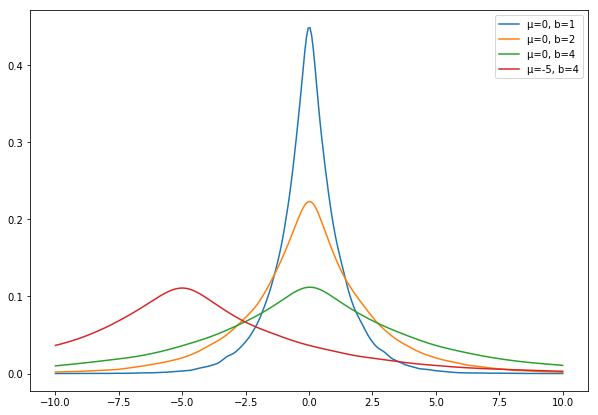

None


In [30]:
// let's draw LaplaceDistribution density plot 
// try to reproduce picture in https://en.wikipedia.org/wiki/Laplace_distribution
import Python
let plt = Python.import("matplotlib.pyplot")
let np = Python.import("numpy")
let stats = Python.import("scipy.stats")
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

let samples = 100000
let range = np.linspace(-10, 10, 300)
var legend: [String] = []
plt.figure(figsize: [10, 7])
for (l, s) in [(0, 1), (0, 2), (0, 4), (-5, 4)] {
  let ldist = LaplaceDistribution(location: Float(l), scale: Float(s))
  var nums: [Float] = []
  for _ in 0..<samples {
    nums.append(ldist.next(using: &PhiloxRandomNumberGenerator.global))
  }
  let density = stats.gaussian_kde(np.array(nums))
  plt.plot(range, density(range))
  legend.append("μ=\(l), b=\(s)")
}
plt.legend(legend)
plt.show()


In [0]:
typealias EpsilonDPQuery = (_ db: Database, _ epsilon: Float) -> Float

let sumDPQuery: EpsilonDPQuery = { db, epsilon in
  let sensivity:Float = 1
  let scale = sensivity / epsilon
  let dist = LaplaceDistribution(location: 0, scale: scale)
  return sumQuery(db) + dist.next(using: &PhiloxRandomNumberGenerator.global)
}

let meanDPQuery: EpsilonDPQuery = { db, epsilon in 
  let sensivity:Float = 1 / Float(db.shape[0])
  let scale = sensivity / epsilon
  let dist = LaplaceDistribution(location: 0, scale: scale)
  return meanQuery(db) + dist.next(using: &PhiloxRandomNumberGenerator.global)
}

In [28]:
for f in ["sum", "mean"] {
  let db = createRandomBinaryVector(of: [5000])
  for eps:Float in [0.001, 0.01, 0.1, 1, 10000] {
    var query: (_ db: Database) -> (orig: Float, dp: Float)
    switch (f) {
      case "sum":
        query = { db in (orig: sumQuery(db), dp: sumDPQuery(db, eps)) }
        break
      case "mean":
        query = { db in (orig: meanQuery(db), dp: meanDPQuery(db, eps)) }
        break
      default:
        fatalError("don't know \(f)")
        break
    }

    print("\(f) with eps=\(eps): ", query(db))
  }
}

sum with eps=0.001:  (orig: 2531.0, dp: 3604.1633)
sum with eps=0.01:  (orig: 2531.0, dp: 2491.4502)
sum with eps=0.1:  (orig: 2531.0, dp: 2517.6982)
sum with eps=1.0:  (orig: 2531.0, dp: 2530.9849)
sum with eps=10000.0:  (orig: 2531.0, dp: 2531.0)
mean with eps=0.001:  (orig: 0.5044, dp: 0.40109968)
mean with eps=0.01:  (orig: 0.5044, dp: 0.44753224)
mean with eps=0.1:  (orig: 0.5044, dp: 0.50114363)
mean with eps=1.0:  (orig: 0.5044, dp: 0.5038255)
mean with eps=10000.0:  (orig: 0.5044, dp: 0.5044)
